In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from sklearn import linear_model as lm
from fuzzywuzzy import fuzz
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

282833 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['baseline_measurements',
                   'result_groups',
                   'eligibilities',
                   'outcomes',
                   'outcome_counts',
                   'outcome_measurements'])
ss.refresh_dim_data()

Successfuly added these 6 dimensions: ['baseline_measurements', 'result_groups', 'eligibilities', 'outcomes', 'outcome_counts', 'outcome_measurements']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 566 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension eligibilities
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index


In [5]:
# setting all the dimensional data to variables
bm = ss.dimensions['baseline_measurements'].data
rg = ss.dimensions['result_groups'].data
el = ss.dimensions['eligibilities'].data
out = ss.dimensions['outcomes'].data
oc = ss.dimensions['outcome_counts'].data
om = ss.dimensions['outcome_measurements'].data

In [6]:
# total number of studies
num_all = ss.studies.shape[0]
num_all

282833

In [7]:
# baseline measurement studies
bm_all = bm.index.get_level_values(0).unique().shape[0]
bm_all, bm_all / num_all

(43592, 0.15412628653657812)

### Finding age like fields:

In [8]:
bm.columns

Index(['id', 'ctgov_group_code', 'classification', 'category', 'title',
       'description', 'units', 'param_type', 'param_value', 'param_value_num',
       'dispersion_type', 'dispersion_value', 'dispersion_value_num',
       'dispersion_lower_limit', 'dispersion_upper_limit',
       'explanation_of_na'],
      dtype='object')

In [9]:
bm.groupby('title').size().sort_values(ascending=False)[:20]

title
Sex: Female, Male                                               241101
Age                                                             229132
Race (NIH/OMB)                                                  225548
Region of Enrollment                                            118678
Race/Ethnicity, Customized                                      105003
Ethnicity (NIH/OMB)                                              73674
Age, Customized                                                  35540
Gender                                                            7416
Sex/Gender, Customized                                            5120
Weight                                                            5060
Height                                                            3788
Body Mass Index (BMI)                                             3263
Education                                                         2534
Eastern Cooperative Oncology Group (ECOG) Performance Status      2199


In [10]:
used_titles = ['Age', 'Age, Customized']
used_types = ['Count of Participants', 'Number']

bm_used = bm[(bm['title'].isin(used_titles)) & (bm['param_type'].isin(used_types))]

# Steps 1-3 are investigative, step 4 starts implementation

# 1. Category column in BM

In [11]:
bmr = bm_used.reset_index()

In [12]:
all_cats = bmr.groupby('category')['nct_id'].count().sort_values(ascending=False)
all_cats[:30]

category
>=65 years                                  40104
<=18 years                                  40069
Between 18 and 65 years                     40062
                                            30320
≥ 65 years                                    191
< 65 years                                    175
18 - 64 years                                  58
≥ 75 years                                     56
50-59 years                                    56
LTE18                                          52
GTE65                                          52
Children (2-11 years)                          52
<65 years                                      52
BTWN                                           52
60-69 years                                    51
40-49 years                                    46
Adults (18-64 years)                           44
>=75 years                                     43
30-39 years                                    42
18-64 years                              

### we can use all of these categories ...

In [13]:
num_used = len(bm_used.index.get_level_values(0).unique())
num_used

18872

In [14]:
# this % of studies is covered by the current set
num_used / bm_all

0.4329234721967333

In [15]:
# eye balling through some of them
np.random.choice(bm_used.index.get_level_values(0).unique(), 5)

array(['NCT01557894', 'NCT00353418', 'NCT01055782', 'NCT01072032',
       'NCT01044966'], dtype=object)

# 2. Merging the category and classification into 1 used study set

In [16]:
double_counts = bm_used.groupby(['classification', 'category'])['id'].count().sort_values(ascending=False)
double_counts[double_counts > 500]

classification           category               
                         >=65 years                 39979
                         <=18 years                 39941
                         Between 18 and 65 years    39937
>=65 years                                           1462
Between 18 and 65 years                               666
<=18 years                                            626
<65 years                                             570
< 65 years                                            540
Name: id, dtype: int64

### Plan: We look at category first, then in the remaining where category is blank, look at the classification

## 3 a) Case 1: Category is non-blank

In [17]:
bm_used_case1 = bm_used[bm_used['category'] != '']

In [18]:
bm_used_case1.groupby('param_type').size()

param_type
Count of Participants    125293
dtype: int64

In [19]:
bm_used_case1 = bm_used_case1[bm_used_case1['param_type'] == 'Count of Participants']

# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case1.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case1_nct_ids = bm_used_case1.index.get_level_values(0).unique()

Pct of bm rows: 80.5%


In [20]:
bm_full_case1 = bm_used.loc[case1_nct_ids]
bm_full_case1 = bm_full_case1[bm_full_case1['param_type'] == 'Count of Participants']
print("Pct of bm rows: %.1f%%" % (bm_full_case1.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 80.6%


## Joining to result groups to get the group labels:

In [21]:
dfm_case1 = bm_full_case1.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [22]:
dfm_case1.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'All Study Participants',
       'Control Group', 'All Participants', 'Usual Care', 'Group 1',
       'Treatment', 'Intervention', 'Overall Study', 'Placebo Group',
       'Entire Study Population', 'Arm 1', 'Sugar Pill', 'Group 2',
       'Total Title', 'Standard of Care', 'Arm I', 'Single Arm', 'Arm 2',
       'All Patients', 'Group B', 'Group A', 'Cohort 1', 'Experimental',
       'Vehicle', 'Intervention Group', 'Cohort 2', 'All Subjects',
       'Treatment Group', 'Active', 'Metformin', 'Normal Saline',
       'Treatment Arm', 'Group 3', 'Standard Care', 'Control Arm',
       'Healthy Volunteers', 'Lacosamide', 'Saline', 'Placebo Arm', 'Cohort 3',
       'Varenicline', 'Arm A', 'Aripiprazole', 'Ketamine', 'Levetiracetam',
       'Arm B', 'Sitagliptin'],
      dtype='object', name='title_rg')

In [23]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [24]:
dfm_case1_nontot = dfm_case1[~dfm_case1['title_rg'].isin(total_strings)].copy()
len(dfm_case1_nontot['nct_id'].unique())

15205

In [25]:
dfm_case1_nontot['param_type'].unique()

array(['Count of Participants'], dtype=object)

In [26]:
df_case1_totcounts = dfm_case1_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c1j = df_case1_totcounts.join(ss.studies[['enrollment']])
df_c1j['tot_per_enroll'] = df_c1j['param_value_num'] / df_c1j['enrollment']
df_c1j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000134,279.0,279.0,1.0
NCT00000135,209.0,209.0,1.0
NCT00000136,234.0,234.0,1.0
NCT00000142,64.0,64.0,1.0
NCT00000143,61.0,61.0,1.0


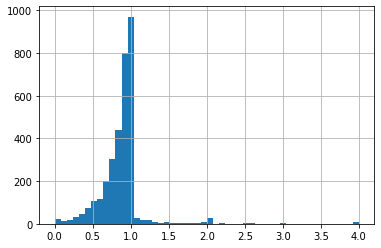

In [27]:
df_c1j[df_c1j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

### Idea: let's just keep those studies with totals that sum up to smaller or equal to total enrollment

In [28]:
non_double_counted = df_c1j[df_c1j['param_value_num'] <= df_c1j['enrollment']]
non_double_counted.shape[0] / df_c1j.shape[0]

0.9861887536994409

In [29]:
df_final_case1 = dfm_case1_nontot[dfm_case1_nontot['nct_id'].isin(non_double_counted.index)].copy()

In [30]:
# % of rows in bm_used
df_final_case1.shape[0] / bm_used.shape[0]

0.5905997570897032

In [31]:
# % of nct_ids in bm_used
len(df_final_case1['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.7945633743111488

## 3 b) Case 2: Category is blank (look in the classification field)

In [32]:
bm_used_case2 = bm_used[bm_used['category'] == '']

In [33]:
bm_used_case2.groupby('param_type').size()

param_type
Count of Participants     5673
Number                   24647
dtype: int64

In [34]:
# checked that these 2 are the dominate characterstics
bm_used_case2 = bm_used_case2[bm_used_case2['param_type'].isin(['Count of Participants', 
                                                                'Number'])]


# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case2.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case2_nct_ids = bm_used_case2.index.get_level_values(0).unique()

Pct of bm rows: 19.5%


In [35]:
bm_full_case2 = bm_used.loc[case2_nct_ids]
bm_full_case2 = bm_full_case2[bm_full_case2['param_type'].isin(['Count of Participants', 'Number'])]
print("Pct of bm rows: %.1f%%" % (bm_full_case2.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 19.7%


## Joining to result groups to get the group labels:

In [36]:
dfm_case2 = bm_full_case2.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [37]:
dfm_case2.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Vehicle', 'All Participants',
       'Pregabalin', 'Cohort 1', 'Placebo QD', 'Cohort 2',
       'Entire Study Population', 'Control Group', 'Dasatinib', 'Doripenem',
       'Standard of Care', 'Usual Care', 'Dexlansoprazole MR 60 mg QD',
       'Bevacizumab', 'Azilsartan Medoxomil 40 mg QD',
       'Azilsartan Medoxomil 80 mg QD', 'Blinatumomab', 'Intervention',
       'Varenicline', 'Treatment', 'Group 1', 'Maraviroc QD', 'Celecoxib',
       'Adalimumab', 'Maraviroc BID', 'Alogliptin 25 mg QD', 'Ziprasidone',
       'Dexlansoprazole MR 90 mg QD', 'Dimebon', 'Alogliptin 12.5 mg QD',
       'Subcutaneous Insulin', 'Total Title', 'Inhaled Insulin',
       'Fesoterodine', 'Dapagliflozin 10 mg', 'Fingolimod 0.5 mg', 'Sunitinib',
       'All Study Participants', 'Dapagliflozin 5 mg', 'Ixabepilone',
       'Placebo MDPI', 'Rivaroxaban (Xarelto, BAY59-7939)', 'Arm I',
       'Anidulafungin', 'Standard of Care (SOC)', 'Sitagliptin 100 mg',
       'Docetax

In [38]:
# still the same total strings:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [39]:
dfm_case2_nontot = dfm_case2[~dfm_case2['title_rg'].isin(total_strings)].copy()
len(dfm_case2_nontot['nct_id'].unique())

3198

In [40]:
df_case2_totcounts = dfm_case2_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c2j = df_case2_totcounts.join(ss.studies[['enrollment']])
df_c2j['tot_per_enroll'] = df_c2j['param_value_num'] / df_c2j['enrollment']
df_c2j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000392,122.0,215.0,0.567442
NCT00003377,29.0,29.0,1.000000
NCT00003644,542.0,571.0,0.949212
NCT00003869,186.0,186.0,1.000000
NCT00006227,31.0,31.0,1.000000


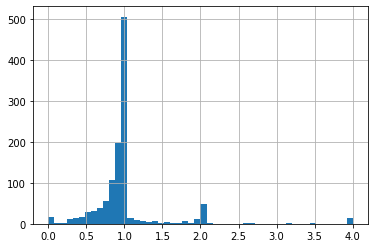

In [41]:
df_c2j[df_c2j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

In [42]:
non_double_counted_case2 = df_c2j[df_c2j['param_value_num'] <= df_c2j['enrollment']]
non_double_counted_case2.shape[0] / df_c2j.shape[0]

0.9521575984990619

In [43]:
df_final_case2 = dfm_case2_nontot[dfm_case2_nontot['nct_id'].isin(non_double_counted_case2.index)].copy()

In [44]:
# % of rows in bm_used
df_final_case2.shape[0] / bm_used.shape[0]

0.13800903523484542

In [45]:
# % of nct_ids in bm_used
len(df_final_case2['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.16135014836795253

### Do we have any nct_ids in both cases?

In [46]:
c1_nct = df_final_case1['nct_id'].unique()
c2_nct = df_final_case2['nct_id'].unique()

[x for x in c1_nct if x in c2_nct]

[]

In [47]:
df_final_case1['used_age'] = df_final_case1['category']
df_final_case2['used_age'] = df_final_case2['classification']

In [48]:
req_columns = [
    'nct_id', 
    'result_group_id',
    'title',
    'ctgov_group_code',
    'used_age',
    'param_value_num'
]

## 4 Joining together the cases

In [49]:
df_final_all = pd.concat([df_final_case1[req_columns], df_final_case2[req_columns]])

In [50]:
df_final_all.shape[0] / bm_used.shape[0]

0.7286087923245487

In [51]:
# % of all nctids that report baseline measures
num_studies_report_race = len(df_final_all['nct_id'].unique())
num_studies_report_race / len(bm.index.get_level_values(0).unique()), num_studies_report_race

(0.41383740135804736, 18040)

In [52]:
dftotals = df_final_all.groupby('nct_id')[['param_value_num']].sum()

In [53]:
df_percentile_totals = dftotals.describe(np.arange(0,1,0.01))
df_percentile_totals.index.name='percentile'
df_percentile_totals.reset_index(inplace=True)
df_percentile_totals = df_percentile_totals[df_percentile_totals['percentile'].apply(lambda x: 
                                                                                     True if '%' in x 
                                                                                     else False)]
df_percentile_totals[15:25]

,percentile,param_value_num
19,15%,11.00
20,16%,11.24
21,17%,12.00
22,18%,13.00
23,19%,14.00
24,20%,15.00
25,21%,15.00
26,22%,16.00
27,23%,17.00
28,24%,18.00


### We picked to keep 80% of the data and exclude any studies such the total <= 15

In [54]:
df_totals_used = dftotals[dftotals['param_value_num'] > 15]
df_totals_used.shape

(14249, 1)

In [55]:
df_final_g15 = df_final_all[df_final_all['nct_id'].isin(df_totals_used.index.unique())]
df_final_g15.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num
3,NCT00000134,18405159,Age,B3,>=65 years,0.0
4,NCT00000134,18405159,Age,B3,Between 18 and 65 years,96.0
5,NCT00000134,18405159,Age,B3,<=18 years,0.0
6,NCT00000134,18405160,Age,B2,>=65 years,0.0
7,NCT00000134,18405160,Age,B2,Between 18 and 65 years,94.0


### Only keep those with 2 Arms or More

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdf86a2cc18>]],
      dtype=object)

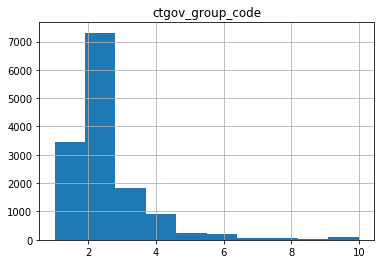

In [56]:
df_final_g15.groupby('nct_id')[['ctgov_group_code']].nunique().clip(0, 10).hist(bins=10)

In [57]:
# only keep studies with greater than 2 arms
s_ngrps = df_final_g15.groupby('nct_id')['ctgov_group_code'].nunique()
nct_id_more_than_2arm = s_ngrps[s_ngrps >= 2].index
len(nct_id_more_than_2arm)

10782

In [59]:
# % of studies with bm
# % of all studies in database
len(nct_id_more_than_2arm) / bm_all, len(nct_id_more_than_2arm) / num_all 

(0.2473389612772986, 0.038121435617484524)

In [61]:
df_more_than_two_arm = df_final_g15[df_final_g15['nct_id'].isin(nct_id_more_than_2arm)].reset_index(drop=True)
df_more_than_two_arm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num
0,NCT00000134,18405159,Age,B3,>=65 years,0.0
1,NCT00000134,18405159,Age,B3,Between 18 and 65 years,96.0
2,NCT00000134,18405159,Age,B3,<=18 years,0.0
3,NCT00000134,18405160,Age,B2,>=65 years,0.0
4,NCT00000134,18405160,Age,B2,Between 18 and 65 years,94.0


# 5. Outcome measurements

In [62]:
omj = om.reset_index().add_prefix('om_')
out_is_prim = out.set_index('id')['outcome_type']
omj['isprim'] = omj['om_outcome_id'].apply(lambda x: out_is_prim[x])

In [63]:
used_dispersion_types = ['Standard Deviation', 'Standard Error']

# filter outcome measurements by just those with mean and std measures
omj_used = omj[(omj['om_param_type'] == 'Mean') & 
               (omj['om_dispersion_type'].isin(used_dispersion_types)) &
               (omj['isprim'] == 'Primary')]

omj_used.shape

(184406, 20)

In [65]:
# studies from the baseline measurement race requirements above
studies_w_race_info = df_more_than_two_arm['nct_id'].unique()
len(studies_w_race_info)

10782

In [66]:
omj_used.head()

,om_nct_id,om_result_group_id,om_outcome_id,om_id,om_ctgov_group_code,om_classification,om_category,om_title,om_description,om_units,om_param_type,om_param_value,om_param_value_num,om_dispersion_type,om_dispersion_value,om_dispersion_value_num,om_dispersion_lower_limit,om_dispersion_upper_limit,om_explanation_of_na,isprim
22,NCT00000371,18405001,5589265,42918129,O2,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,Mean,-.41,-0.41,Standard Error,.31,0.31,NaN,NaN,,Primary
23,NCT00000371,18405002,5589265,42918130,O1,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,Mean,-.46,-0.46,Standard Error,.29,0.29,NaN,NaN,,Primary
24,NCT00000378,18404992,5589264,42918125,O2,12 WEEK DATA,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,8.4,8.40,Standard Deviation,7.7,7.70,NaN,NaN,,Primary
25,NCT00000378,18404992,5589264,42918127,O2,BASELINE,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,27.1,27.10,Standard Deviation,4.4,4.40,NaN,NaN,,Primary
26,NCT00000378,18404993,5589264,42918126,O1,12 WEEK DATA,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,10.7,10.70,Standard Deviation,8.3,8.30,NaN,NaN,,Primary


filter results to those that have equal number of groups

In [67]:
omj_counts = omj_used.groupby('om_nct_id')[['om_ctgov_group_code']].nunique()
df_counts = df_more_than_two_arm.groupby('nct_id')[['ctgov_group_code']].nunique()
df_intersection = omj_counts.join(df_counts, how='inner')
df_intersection_used = df_intersection[df_intersection['om_ctgov_group_code'] ==
                                       df_intersection['ctgov_group_code']]

df_intersection.shape, df_intersection_used.shape

((4239, 2), (3859, 2))

In [69]:
# this dataframe contains the bucket splits for the baseline measurements, already filtered to intersection
df_mta_intersect = df_more_than_two_arm[df_more_than_two_arm['nct_id'].isin(df_intersection_used.index)].copy()
df_mta_intersect.shape

(27808, 6)

In [70]:
# this dataframe contains the bucket splits for the outcome measurements, now filtered to intersection
omj_used_intersect = omj_used[omj_used['om_nct_id'].isin(df_intersection_used.index)].copy()
omj_used_intersect.shape

(34531, 20)

In [71]:
# extracting the numerical group numbers from each dataframe
df_mta_intersect['group_num'] = df_mta_intersect['ctgov_group_code'].apply(lambda x: int(x[1:]))
omj_used_intersect['group_num'] = omj_used_intersect['om_ctgov_group_code'].apply(lambda x: int(x[1:]))

In [72]:
df_mta_intersect.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num,group_num
36,NCT00000371,18404997,Age,B2,>=65 years,0.0,2
37,NCT00000371,18404997,Age,B2,Between 18 and 65 years,28.0,2
38,NCT00000371,18404997,Age,B2,<=18 years,0.0,2
39,NCT00000371,18404998,Age,B1,>=65 years,0.0,1
40,NCT00000371,18404998,Age,B1,Between 18 and 65 years,27.0,1


In [73]:
omj_used_intersect.head(2)

,om_nct_id,om_result_group_id,om_outcome_id,om_id,om_ctgov_group_code,om_classification,om_category,om_title,om_description,om_units,...,om_param_value,om_param_value_num,om_dispersion_type,om_dispersion_value,om_dispersion_value_num,om_dispersion_lower_limit,om_dispersion_upper_limit,om_explanation_of_na,isprim,group_num
22,NCT00000371,18405001,5589265,42918129,O2,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,...,-.41,-0.41,Standard Error,.31,0.31,NaN,NaN,,Primary,2
23,NCT00000371,18405002,5589265,42918130,O1,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,...,-.46,-0.46,Standard Error,.29,0.29,NaN,NaN,,Primary,1


In [74]:
# Set random seed here
USED_RANDOM_SEED = 100
np.random.seed(USED_RANDOM_SEED)

selected_bm_rows = []
selected_om_rows = []
random_summary = {}


# loop through studies to randomely select the groups, and 1 random primary outcome
for nct_id in tqdm(df_intersection_used.index):
    subdf_bm = df_mta_intersect[df_mta_intersect['nct_id'] == nct_id]
    subdf_om = omj_used_intersect[omj_used_intersect['om_nct_id'] == nct_id]
    
    # 1 random outcome measure
    possible_outcome_ids = subdf_om['om_outcome_id'].unique()
    selected_outcome_id = np.random.choice(possible_outcome_ids)
    subdf_om_used = subdf_om[subdf_om['om_outcome_id'] == selected_outcome_id]
    
    possible_groups = subdf_bm['group_num'].unique()
    selected_groups = np.random.choice(possible_groups, 2, replace=False)  # no replacement
    
    selected_bm = subdf_bm[subdf_bm['group_num'].isin(selected_groups)]
    selected_om = subdf_om_used[subdf_om_used['group_num'].isin(selected_groups)]
    
    select_bm_num_groups = len(selected_bm['group_num'].unique())
    select_om_num_groups = len(selected_om['group_num'].unique())
    
    if select_bm_num_groups == select_om_num_groups:
        # only capture the entry if there are rows in both
        selected_bm_rows.append(selected_bm)
        selected_om_rows.append(selected_om)

        random_summary_entry = {
            'total_bm_rows': subdf_bm.shape[0],
            'total_om_rows': subdf_om.shape[0],
            'num_outcome_measures': len(possible_outcome_ids),
            'num_possible_groups': len(possible_groups),
            'num_selected_groups': len(selected_groups),
            'selected_bm_rows': selected_bm.shape[0],
            'selected_om_rows': selected_om.shape[0]
        }

        random_summary[nct_id] = random_summary_entry
    else:
        print("did not add %s" % nct_id)

did not add NCT00121641
did not add NCT00128193
did not add NCT00131378
did not add NCT00381849
did not add NCT00457743
did not add NCT00624520
did not add NCT00655083
did not add NCT00671671
did not add NCT00909155
did not add NCT00915525
did not add NCT01079390
did not add NCT01642147
did not add NCT01808209
did not add NCT01822535
did not add NCT01920854
did not add NCT01933880
did not add NCT01947283
did not add NCT01947907
did not add NCT02277119
did not add NCT02310763
did not add NCT02384993
did not add NCT02511782
did not add NCT02568475



In [75]:
df_random_summ = pd.DataFrame(random_summary).T
df_random_summ.index.name = 'nct_id'
df_random_summ.head()

,total_bm_rows,total_om_rows,num_outcome_measures,num_possible_groups,num_selected_groups,selected_bm_rows,selected_om_rows
nct_id,,,,,,,
NCT00000371,6,2,1,2,2,6,2
NCT00000378,6,4,1,2,2,6,4
NCT00000392,2,2,1,2,2,2,2
NCT00000575,9,3,1,3,2,6,2
NCT00001262,9,12,4,3,2,6,2


In [76]:
df_selected_bm = pd.concat(selected_bm_rows)
df_selected_om = pd.concat(selected_om_rows)

In [77]:
num_groups_bm = df_selected_bm.groupby('nct_id')['ctgov_group_code'].nunique()
num_groups_bm.value_counts()

2    3836
Name: ctgov_group_code, dtype: int64

In [78]:
df_selected_om.groupby('om_nct_id')['om_ctgov_group_code'].nunique().value_counts()

2    3836
Name: om_ctgov_group_code, dtype: int64

In [79]:
# number of final studies to compute imbalance and measurements
nct_id_bm = df_selected_bm['nct_id'].unique()
nct_id_om = df_selected_om['om_nct_id'].unique() 

len(nct_id_bm), len(nct_id_om)

(3836, 3836)

In [80]:
final_nct_id_list = df_selected_bm['nct_id'].unique()
final_nct_id_list

array(['NCT00000371', 'NCT00000378', 'NCT00000392', ..., 'NCT04502979',
       'NCT04512482', 'NCT04574999'], dtype=object)

### Previously this count was 1.2k

## On the outcome counts, getting the primary counts

In [81]:
# requires the outcome table and the outcome_counts table
ocj = oc.reset_index().add_prefix('oc_')
out_ocj = out[['id', 'outcome_type']].reset_index().add_prefix('oco_')

ocoj = ocj.merge(out_ocj,
                 how='inner', 
                 left_on=['oc_nct_id', 'oc_outcome_id'],
                 right_on=['oco_nct_id', 'oco_id'])
ocoj_in_set = ocoj[ocoj['oc_nct_id'].isin(final_nct_id_list)]

# only keep counts on primary out comes
ocoj_primary = ocoj_in_set[ocoj_in_set['oco_outcome_type'] == 'Primary']

len(ocoj_primary['oc_nct_id'].unique())

3836

In [82]:
# extracting the outcome counts:
res_dict = {}

for nct_id in tqdm(ocoj_primary['oc_nct_id'].unique()):
    #print(nct_id)
    sub_df = ocoj_primary[ocoj_primary['oc_nct_id'] == nct_id]
    for gcode in sub_df['oc_ctgov_group_code'].unique():
        sub_df_gc = sub_df[sub_df['oc_ctgov_group_code'] == gcode]
        type_units = sub_df_gc['oc_units'].unique()

        if len(type_units) == 1:
            num_participants = sub_df_gc['oc_count'].values[0]
            num_measures = sub_df_gc['oc_count'].values[0]  # same as participants
        elif len(type_units) == 2:
            num_participants = sub_df_gc[sub_df_gc['oc_units'] == 'Participants']['oc_count'].values[0]
            num_measures = sub_df_gc[sub_df_gc['oc_units'] != 'Participants']['oc_count'].values[0]

        res_dict[(nct_id, gcode)] = {
            'num_participants': num_participants,
            'num_measures': num_measures,
        }
        
df_counts = pd.DataFrame(res_dict).T
df_counts.index.names = ['nct_id', 'ctgov_group_code']
df_counts = df_counts.reset_index().add_prefix('ct_')
df_counts

,ct_nct_id,ct_ctgov_group_code,ct_num_participants,ct_num_measures
0,NCT00000371,O2,27,27
1,NCT00000371,O1,28,28
2,NCT00000378,O2,52,52
3,NCT00000378,O1,58,58
4,NCT00000392,O2,77,77
...,...,...,...,...
9269,NCT04502979,O1,28,28
9270,NCT04512482,O2,43,43
9271,NCT04512482,O1,43,43
9272,NCT04574999,O2,53,53


In [83]:
df_selected_om_w_counts = df_selected_om.merge(df_counts,
                                               how='inner',
                                               left_on=['om_nct_id', 'om_ctgov_group_code'],
                                               right_on=['ct_nct_id', 'ct_ctgov_group_code'])

In [84]:
df_selected_om_w_counts.shape

(13430, 25)

In [85]:
df_selected_bm.shape

(22868, 7)

In [86]:
df_selected_bm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_age,param_value_num,group_num
36,NCT00000371,18404997,Age,B2,>=65 years,0.0,2
37,NCT00000371,18404997,Age,B2,Between 18 and 65 years,28.0,2
38,NCT00000371,18404997,Age,B2,<=18 years,0.0,2
39,NCT00000371,18404998,Age,B1,>=65 years,0.0,1
40,NCT00000371,18404998,Age,B1,Between 18 and 65 years,27.0,1


In [87]:
df_selected_om_w_counts.to_pickle('om.p')
df_selected_bm.to_pickle('bm.p')

## Incorporate result group data into the output measurements 

In [88]:
# joining the result groups to dfom
rg_omj = rg.reset_index().add_prefix("rgom_")
dfom_final_ij = df_selected_om_w_counts.merge(rg_omj,
                                              how='inner',
                                              left_on=['om_nct_id', 'om_result_group_id'],
                                              right_on=['rgom_nct_id', 'rgom_id'])
dfom_final_ij.shape

(13430, 31)

In [89]:
# joining the result groups to dfbm
rg_bmj = rg.reset_index().add_prefix("rgbm_")
dfbm_final_ij = df_selected_bm.merge(rg_bmj,
                                     how='inner',
                                     left_on=['nct_id', 'result_group_id'],
                                     right_on=['rgbm_nct_id', 'rgbm_id'])
dfbm_final_ij.shape

(22868, 13)

In [90]:
# saving pickles
dfbm_final_ij.to_pickle('final_bm.p')
dfom_final_ij.to_pickle('final_om.p')

# 7. Compute imbalance and effect from the data

**Imbalance:**

Let $a_1, a_2, ..., a_n$ be % of the participants by race in group 1

Let $b_1, b_2, ..., b_n$ be % of the participants by race in group 2

Where n is the number of race classes in the study.

Define imbalance as: 

$ \sqrt{ \Sigma_{i=1}^{n} (a_i - b_i) ^ 2 }$

Can see in the extreme cases:

1) if $a_i = b_i, \forall i$ Then the imbalance measure = 0

2) if fully disjoint, i.e. $a_i = 0 \text{ or } b_i = 0 , \forall i$, then imbalance measure = 1

**Effect:**

$$ \left\lvert \frac{\text{Mean Outcome in Arm 1 − Mean Outcome in Arm 2}}{\text{Standard Error of Outcomes}} \right\rvert $$

Where denominator: Standard Error of Outcomes is estimated as Follows:

Let $n_1, n_2$ be reported number of measurements in group 1 and 2 respectively

Let $\sigma_1, \sigma_2$ be the reported standard deviation of the measurements in group 1 and 2 respectively

Estimated Standard Error of Outcomes = 
$$\sqrt{\frac{n_1 \sigma_1^2 + n_2 \sigma_2^2}{n_1 + n_2}}$$

In [94]:
# loop to compute all effects and imbalances
all_res = {}  # storing final results

for nct_id in tqdm(dfom_final_ij['om_nct_id'].unique()):
    all_res[nct_id] = {}  # inner dict for storage
    sub_om = dfom_final_ij[dfom_final_ij['om_nct_id'] == nct_id]
    sub_bm = dfbm_final_ij[dfbm_final_ij['nct_id'] == nct_id]
    
    # difference in mean
    abs_mean_diff = np.abs(sub_om['om_param_value_num'].values[0] - sub_om['om_param_value_num'].values[1])
    
    # standard error estimate
    sd_type1 = sub_om['om_dispersion_type'].values[0]
    sd_type2 = sub_om['om_dispersion_type'].values[1]
    num_m1 = sub_om['ct_num_measures'].values[0]
    num_m2 = sub_om['ct_num_measures'].values[1]
    sd_1 = sub_om['om_dispersion_value_num'].values[0]
    sd_2 = sub_om['om_dispersion_value_num'].values[1]
    
    # if the type is Standard Error, then we need to scale it by the sqrt of the count, since it has been adjusted
    if sd_type1 == 'Standard Error':
        sd_1 = sd_1 * np.sqrt(num_m1)
    if sd_type2 == 'Standard Error':
        sd_2 = sd_2 * np.sqrt(num_m2)
    
    sd_est = np.sqrt((num_m1 * sd_1 ** 2 + num_m2 * sd_2 **2) / (num_m1 + num_m2))
    
    effect = abs_mean_diff / sd_est
    all_res[nct_id]['effect'] = effect
    
    # details
    all_res[nct_id]['g1_mean'] = num_m1
    all_res[nct_id]['g2_mean'] = num_m2
    all_res[nct_id]['g1_sd_sample'] = sd_1
    all_res[nct_id]['g2_sd_sample'] = sd_2
    
    
    # imbalance
    bm_g_sums = sub_bm.groupby(['ctgov_group_code', 'used_age'])[['param_value_num']].sum().reset_index()
    dfp = bm_g_sums.pivot(columns='used_age', index='ctgov_group_code', values='param_value_num')
    
    if dfp.shape[0] > 2:
        break
    
    dfp.index = ['g1', 'g2']  # rename to standardize the indices
    
    dfpct = dfp.T / dfp.sum(axis=1)
    dfpct['abs_diff'] = np.abs(dfpct['g1'] - dfpct['g2'])
    imbal = np.sqrt((dfpct['abs_diff'] ** 2).sum())
    all_res[nct_id]['imbal'] = imbal
        
    # number of groups
    all_res[nct_id]['ngrps'] = sub_bm.shape[0] / 2
    
    # other details
    all_res[nct_id]['g1t'] = dfp.T['g1'].sum()
    all_res[nct_id]['g2t'] = dfp.T['g2'].sum()
    all_res[nct_id]['g1counts'] = dfp.T['g1'].values
    all_res[nct_id]['g2counts'] = dfp.T['g2'].values
    all_res[nct_id]['grouplabels'] = list(dfp.T.index)
    
    
df_res = pd.DataFrame(all_res).T.dropna()
df_res.head()

/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000371,0.0317977,27,28,1.61081,1.53454,0,3,27,28,"[0.0, 0.0, 27.0]","[0.0, 0.0, 28.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00000378,2.982,52,52,7.7,4.4,0.0862783,3,58,52,"[0.0, 50.0, 8.0]","[0.0, 48.0, 4.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00000392,0.237493,77,66,0.263249,0.406202,0,1,60,62,[60.0],[62.0],[18-39 years]
NCT00000575,0.114583,307,306,9.6,9.6,0,3,311,312,"[311.0, 0.0, 0.0]","[312.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00001262,1.37185,22,35,1.652,12.762,0,3,35,22,"[35.0, 0.0, 0.0]","[22.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"


In [95]:
# lost 1 record due to Nan in the numerical values
df_res.shape

(3803, 12)

### Exclude those with just 1 group

In [96]:
df_res_mult_grps = df_res[df_res['ngrps'] > 1].copy()
df_res.shape[0], df_res_mult_grps.shape[0]

(3803, 3738)

In [97]:
# casting ...
df_res_mult_grps['effect'] = df_res_mult_grps['effect'].astype(float)
df_res_mult_grps['g1_mean'] = df_res_mult_grps['g1_mean'].astype(float)
df_res_mult_grps['g2_mean'] = df_res_mult_grps['g2_mean'].astype(float)
df_res_mult_grps['g1_sd_sample'] = df_res_mult_grps['g1_sd_sample'].astype(float)
df_res_mult_grps['g2_sd_sample'] = df_res_mult_grps['g2_sd_sample'].astype(float)
df_res_mult_grps['imbal'] = df_res_mult_grps['imbal'].astype(float)
df_res_mult_grps['ngrps'] = df_res_mult_grps['ngrps'].astype(int)
df_res_mult_grps['g1t'] = df_res_mult_grps['g1t'].astype(int)
df_res_mult_grps['g2t'] = df_res_mult_grps['g2t'].astype(int)


In [100]:
# cleaned dataset
df_res_mult_grps.to_pickle('res_age_randomized.p')

In [101]:
df_res_mult_grps.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000371,0.031798,27.0,28.0,1.610807,1.534536,0.000000,3,27,28,"[0.0, 0.0, 27.0]","[0.0, 0.0, 28.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00000378,2.981997,52.0,52.0,7.700000,4.400000,0.086278,3,58,52,"[0.0, 50.0, 8.0]","[0.0, 48.0, 4.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00000575,0.114583,307.0,306.0,9.600000,9.600000,0.000000,3,311,312,"[311.0, 0.0, 0.0]","[312.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00001262,1.371846,22.0,35.0,1.652000,12.762000,0.000000,3,35,22,"[35.0, 0.0, 0.0]","[22.0, 0.0, 0.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
NCT00001304,5.004346,14.0,13.0,0.020000,0.010000,0.168279,3,13,14,"[1.0, 0.0, 12.0]","[2.0, 1.0, 11.0]","[<=18 years, >=65 years, Between 18 and 65 years]"
